In [1]:
try:
  # %tensorflow_version only exists i
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
#tensorflow related modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop


In [9]:
from pathlib import Path
import os
import random
import urllib.request
import zipfile
from shutil import copyfile

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
%matplotlib inline

In [5]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"

In [6]:
file_name = 'catsdogs.zip'
download_dir = '/tmp/'
urllib.request.urlretrieve(url, file_name)

('catsdogs.zip', <http.client.HTTPMessage at 0x7fefd4bc4970>)

In [7]:
zip_ref = zipfile.ZipFile(file_name,'r')
zip_ref.extractall(download_dir)

zip_ref.close()

In [25]:
Path.ls = lambda x:(list(x.iterdir()))

In [26]:
path  = Path(download_dir)

In [29]:
len([i for i in (path/'PetImages/Cat').ls()]),len([i for i in (path/'PetImages/Dog').ls()])

(12501, 12501)

In [30]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [31]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [32]:
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


In [33]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [34]:
train_generator= train_datagen.flow_from_directory(TRAINING_DIR, batch_size= 100,
                                                  class_mode = 'binary', 
                                                  target_size = (150, 150))

Found 22498 images belonging to 2 classes.


In [35]:
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 2499 images belonging to 2 classes.


In [36]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7fefd34db070>)

In [39]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                               include_top = False,
                               weights = None)
pre_trained_model.load_weights(weights_file)

In [41]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [42]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [47]:
last_layer_name = pre_trained_model.layers[-1].name

In [48]:
last_layer = pre_trained_model.get_layer(last_layer_name)

In [49]:
last_layer.output_shape

(None, 3, 3, 2048)

In [50]:
last_layer_output = last_layer.output

In [52]:
x = layers.Flatten()(last_layer_output)
x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)


model = Model(inputs = pre_trained_model.input,outputs  = x)

In [54]:
model.compile(optimizer  = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_generator, validation_data = validation_generator, epochs = 2, verbose = 1)

Epoch 1/2
  1/225 [..............................] - ETA: 0s - loss: 1.5923 - acc: 0.5700

/home/hasan/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/home/hasan/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/home/hasan/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/home/hasan/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/home/hasan/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 

225/225 [==============================] - 160s 710ms/step - loss: 0.5610 - acc: 0.8851 - val_loss: 0.0974 - val_acc: 0.9644
Epoch 2/2
225/225 [==============================] - 159s 706ms/step - loss: 0.2011 - acc: 0.9197 - val_loss: 0.2249 - val_acc: 0.9352


In [56]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

<Figure size 432x288 with 0 Axes>

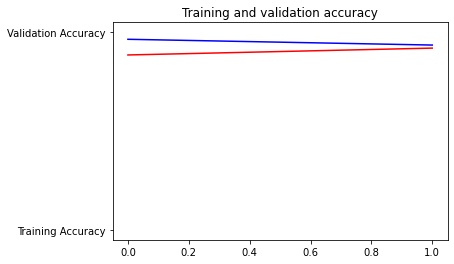

<Figure size 432x288 with 0 Axes>

In [58]:
epochs=range(len(acc)) # Get number of epochs
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


In [59]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")




ModuleNotFoundError: No module named 'google.colab'

In [1]:
!nvidia-smi

Sun Dec 13 15:14:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:0A:00.0  On |                  N/A |
|  0%   36C    P8    27W / 300W |    823MiB / 10997MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

In [12]:
[tf.random.uniform((),0,48, dtype=tf.int32).numpy() for i in range(10)]

[35, 6, 8, 34, 28, 0, 29, 41, 33, 20]

In [1]:
from sys import argv

In [3]:
compile(open(argv[1]).read(),argv[1],'exec',0,1)

FileNotFoundError: [Errno 2] No such file or directory: '-f'